<a href="https://colab.research.google.com/github/fengnanqiao/Minor-thesis/blob/master/SmokeNet_Liang_DaraAug_Additional_Modules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import os
import pathlib
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from keras import callbacks
#import PIL
#import PIL.Image
#import torch
#from torch import nn
#import pydot
#import pydrive

In [ ]:
!pip install tensorflow_io
import tensorflow_io as tfio

In [ ]:
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials

#### Mount Google drive to access dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### unzip dataset to assigned folder

In [ ]:
# !unzip "/content/gdrive/My Drive/Colab Notebooks/USTC_SmokeRS.zip" -d "/content/gdrive/My Drive/Colab Notebooks/SmokeDataset"

#### make an alias of the root folder

In [ ]:
smoke_root = pathlib.Path("/content/gdrive/My Drive/Colab Notebooks/SmokeDataset")

#### list the data in the dataset and look at 5 random examples

In [ ]:
list_ds = tf.data.Dataset.list_files(str(smoke_root/'*/*'), shuffle=False)
image_count = len(list_ds)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [ ]:
for f in list_ds.take(5):
  print(f.numpy())

b'/content/gdrive/My Drive/Colab Notebooks/SmokeDataset/Dust/dust_917.tif'
b'/content/gdrive/My Drive/Colab Notebooks/SmokeDataset/Haze/haze_936.tif'
b'/content/gdrive/My Drive/Colab Notebooks/SmokeDataset/Smoke/smoke_450.tif'
b'/content/gdrive/My Drive/Colab Notebooks/SmokeDataset/Seaside/seaside_283.tif'
b'/content/gdrive/My Drive/Colab Notebooks/SmokeDataset/Cloud/cloud_296.tif'


## Get class name and order by alphabet. split training and testing dataset and define batch size

In [ ]:
class_names = np.array(sorted([item.name for item in smoke_root.glob('*') if item.name != "NULL"]))
print(class_names)

['Cloud' 'Dust' 'Haze' 'Land' 'Seaside' 'Smoke']


In [ ]:
train_size = int(0.8 * 6225)
AUTOTUNE=tf.data.experimental.AUTOTUNE
batch_size = 32
IMG_SIZE = 128

In [ ]:
train_ds = list_ds.take(train_size)
test_ds = list_ds.skip(train_size)

In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())
train_ds

4980
1245


<TakeDataset shapes: (), types: tf.string>

In [ ]:
for i in train_ds.take(1):
  print(i)
  #img = tf.io.read_file(i)

#img = tfio.experimental.image.decode_tiff(img)

tf.Tensor(b'/content/gdrive/My Drive/Colab Notebooks/SmokeDataset/Dust/dust_917.tif', shape=(), dtype=string)


In [ ]:
#img = tf.image.resize(img, [128, 128])
#img

#### Read the data using the tf.io.read_file function and extract the label from the path, decode the image, return decoded image and label pair

In [ ]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [ ]:
def decode_img(img):
  # convert the compressed string to a 4D uint8 tensor
  img = tfio.experimental.image.decode_tiff(img)
  # resize the image to the desired size
  img = tf.image.convert_image_dtype(img, tf.float32) # this operation also normalises the pixel value to be in [0-1]
  img = tf.image.resize(img, [128, 128])
  return img

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

### map process_path to train_ds and test_ds, set parallel processing

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
train_ds

<ParallelMapDataset shapes: ((128, 128, None), ()), types: (tf.float32, tf.int64)>

In [ ]:
for image, label in train_ds.take(2):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (128, 128, 4)
Label:  1
Image shape:  (128, 128, 4)
Label:  2


In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())

4980


## Data Augmentation on dataset

In [ ]:
#data_augmentation = tf.keras.Sequential([
#  preprocessing.RandomFlip("horizontal_and_vertical"),
#  preprocessing.RandomRotation(0.2),
#  preprocessing.RandomCrop(124,124),
#  preprocessing.Resizing(128,128),
#])

In [ ]:
def augment(image,label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6) 
   # Random crop back to the original size
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE,4])
  #image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  #image = tf.clip_by_value(image, 0, 1)
  return image, label

In [ ]:
#def prepare(ds):
#  ds = ds.map(lambda x, y: (tf.squeeze(data_augmentation(tf.expand_dims(x, 0)),0), y), 
#              num_parallel_calls=AUTOTUNE)

#  return ds

In [ ]:
new_train = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
new_train

<PrefetchDataset shapes: ((None, 128, 128, 4), (None,)), types: (tf.float32, tf.int64)>

In [ ]:
train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(AUTOTUNE)
train_ds

<PrefetchDataset shapes: ((None, 128, 128, None), (None,)), types: (tf.float32, tf.int64)>

In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(new_train).numpy())

156
156


In [ ]:
train_ds_final = train_ds.concatenate(new_train)
train_ds_final

<ConcatenateDataset shapes: ((None, 128, 128, None), (None,)), types: (tf.float32, tf.int64)>

In [ ]:
print(tf.data.experimental.cardinality(train_ds_final).numpy())

312


In [ ]:
#image = tf.expand_dims(image, 0)

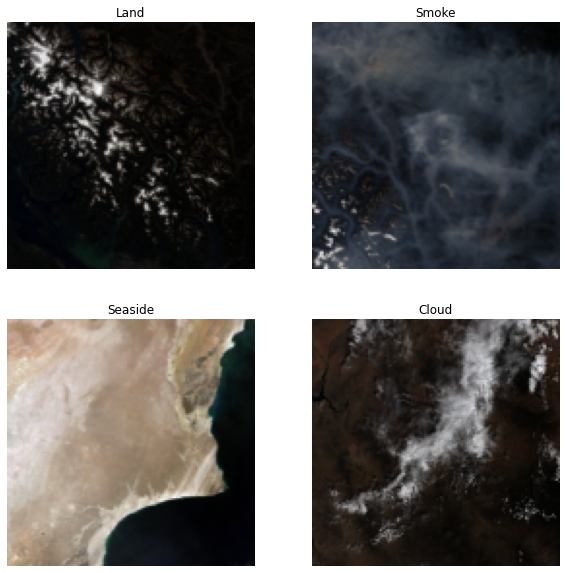

In [ ]:
image_batch, label_batch = next(iter(train_ds_final))

plt.figure(figsize=(10, 10))
for i in range(4):
  #print(np.min(image_batch[i]), np.max(image_batch[i])) 
  ax = plt.subplot(2, 2, i + 1)
  plt.imshow(image_batch[i].numpy(), cmap=plt.cm.binary)
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [ ]:
label_batch

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([3, 5, 4, 0, 0, 3, 4, 4, 1, 2, 3, 4, 4, 3, 0, 0, 4, 1, 0, 5, 0, 5,
       3, 0, 3, 3, 5, 0, 1, 2, 4, 2])>

In [ ]:
image_batch[5]

<tf.Tensor: shape=(128, 128, 4), dtype=float32, numpy=
array([[[0.27058825, 0.25686276, 0.21960786, 1.        ],
        [0.27058825, 0.25392157, 0.21764708, 1.        ],
        [0.24313727, 0.2392157 , 0.20588237, 1.        ],
        ...,
        [0.23529413, 0.21960786, 0.11960785, 1.        ],
        [0.15490198, 0.16568628, 0.0764706 , 1.        ],
        [0.13333334, 0.15882353, 0.06960785, 1.        ]],

       [[0.28921568, 0.2617647 , 0.2264706 , 1.        ],
        [0.2676471 , 0.25      , 0.21666668, 1.        ],
        [0.2529412 , 0.24117649, 0.20882355, 1.        ],
        ...,
        [0.3137255 , 0.2529412 , 0.15784314, 1.        ],
        [0.21960786, 0.19411767, 0.09901962, 1.        ],
        [0.14117648, 0.15294118, 0.06470589, 1.        ]],

       [[0.28431374, 0.25588238, 0.22156864, 1.        ],
        [0.2901961 , 0.25882354, 0.22352943, 1.        ],
        [0.2784314 , 0.2509804 , 0.2137255 , 1.        ],
        ...,
        [0.20980394, 0.18235296,

In [ ]:
for img, label in train_ds_final.take(1):
  print("image:", img)
  print("label:", label)


image: tf.Tensor(
[[[[0.04901961 0.05588236 0.05588236 1.        ]
   [0.04803922 0.05392157 0.05294118 1.        ]
   [0.0627451  0.06960785 0.06862745 1.        ]
   ...
   [0.06372549 0.1264706  0.11470589 1.        ]
   [0.05686275 0.12058824 0.10686275 1.        ]
   [0.06176471 0.1254902  0.11176471 1.        ]]

  [[0.02058824 0.02941177 0.02941177 1.        ]
   [0.02254902 0.02941177 0.02941177 1.        ]
   [0.01764706 0.02450981 0.02450981 1.        ]
   ...
   [0.04803922 0.11078432 0.10000001 1.        ]
   [0.04607844 0.10980393 0.09803922 1.        ]
   [0.06372549 0.12450981 0.11568628 1.        ]]

  [[0.01764706 0.02647059 0.02647059 1.        ]
   [0.01666667 0.02450981 0.02450981 1.        ]
   [0.01764706 0.02745098 0.02647059 1.        ]
   ...
   [0.04705883 0.1137255  0.10000001 1.        ]
   [0.05392157 0.12058824 0.10980393 1.        ]
   [0.0627451  0.12156864 0.11470589 1.        ]]

  ...

  [[0.00980392 0.01078431 0.01372549 1.        ]
   [0.00392157 0.

## configure the training data

In [ ]:
def configure_for_performance(ds):
  #ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

#train_ds = configure_for_performance(train_ds)
test_ds = configure_for_performance(test_ds)

## Visualise the data

In [ ]:
#image_batch, label_batch = next(iter(train_ds))

#plt.figure(figsize=(10, 10))
#for i in range(4):
#  print(np.min(image_batch[i]), np.max(image_batch[i])) 
#  ax = plt.subplot(2, 2, i + 1)
#  plt.imshow(image_batch[i].numpy(), cmap=plt.cm.binary)
#  label = label_batch[i]
#  plt.title(class_names[label])
#  plt.axis("off")

## Normalise the images before training

In [ ]:
#from tensorflow.keras import layers
#normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
#train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(train_ds))
#first_image = image_batch[0]
## Notice the pixels values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image)) 

#test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(test_ds))
#first_image = image_batch[0]
## Notice the pixels values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image)) 

## Define the model and start training

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(64,(5,5), activation='relu', input_shape=(128,128,4)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(5,5),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 64)      6464      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         1

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(6))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 64)      6464      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         1

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", 
                                        patience = 5,  
                                        restore_best_weights = True)

train_history = model.fit(
  train_ds_final,
  validation_data=test_ds,
  epochs=50,
  callbacks =[earlystopping]
)

Epoch 1/50
312/312 [==============================] - 877s 3s/step - loss: 1.3154 - accuracy: 0.4546 - val_loss: 1.0884 - val_accuracy: 0.5446
Epoch 2/50
312/312 [==============================] - 26s 83ms/step - loss: 0.9883 - accuracy: 0.6110 - val_loss: 0.9229 - val_accuracy: 0.6418
Epoch 3/50
312/312 [==============================] - 25s 80ms/step - loss: 0.8073 - accuracy: 0.6921 - val_loss: 0.7952 - val_accuracy: 0.6948
Epoch 4/50
312/312 [==============================] - 25s 82ms/step - loss: 0.6840 - accuracy: 0.7485 - val_loss: 0.7122 - val_accuracy: 0.7382
Epoch 5/50
312/312 [==============================] - 26s 83ms/step - loss: 0.5938 - accuracy: 0.7857 - val_loss: 0.6603 - val_accuracy: 0.7655
Epoch 6/50
312/312 [==============================] - 26s 84ms/step - loss: 0.5281 - accuracy: 0.8040 - val_loss: 0.6446 - val_accuracy: 0.7727
Epoch 7/50
312/312 [==============================] - 26s 83ms/step - loss: 0.4769 - accuracy: 0.8254 - val_loss: 0.6159 - val_accuracy: 

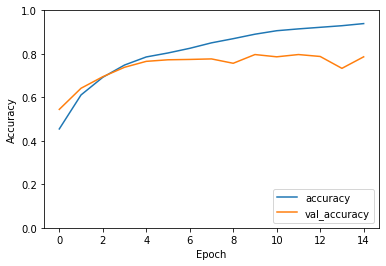

In [ ]:
plt.plot(train_history.history['accuracy'], label='accuracy')
plt.plot(train_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc='lower right')


In [ ]:
print(test_acc)